In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
# %load network-benchmark.py
#!/usr/bin/env python3

import configparser
from functools import lru_cache
import glob
import io
import os

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
# import numpy as np


TEST_RESULT_ROOT = "/Users/esteele/tmp/wifi-test/root/wifi-test-results"
METADATA_FILENAME = "metadata.ini"
TEST_RESULT_GLOB = "*.csv"
TEST_RESULT_DIR_PATTERN = os.path.join(TEST_RESULT_ROOT, "test-run-{0}")
TEST_RESULT_METADATA_FILE = os.path.join(TEST_RESULT_DIR_PATTERN,
                                         METADATA_FILENAME)
TEST_RESULT_FILES_PATTERN = os.path.join(TEST_RESULT_DIR_PATTERN,
                                         TEST_RESULT_GLOB)
DEFAULT_REFERENCE_LINE_Y_VALUE = 250000
BW_DESC = {
    125000: "360p bitrate",
    250000: "480p bitrate",
    500000: "720p bitrate",
}


def get_test_run_results(test_run_id):
    test_result_files_glob = TEST_RESULT_FILES_PATTERN.format(test_run_id)
    result_sio = io.StringIO()
    for csv in glob.iglob(test_result_files_glob):
        with open(csv) as f:
            result_sio.write(f.read())

    # Prime for reading
    result_sio.seek(0)
    return result_sio


def get_dataframe_from_test_run(test_run_id, downscale_factor=1):
    raw_run_data = get_test_run_results(test_run_id)
    summary_data = pd.read_csv(raw_run_data,
                               comment="#",
                               names=["client_id",
                                      "timestamp",
                                      "bytes_per_sec"])
    # Create a time_offset column
    summary_data["time_offset"] = summary_data['timestamp'] - \
        min(summary_data['timestamp'])
    summary_data["time_offset"] = \
        (summary_data["time_offset"] // downscale_factor) * downscale_factor
    summary_data["time_offset"] = \
        pd.to_timedelta(summary_data['time_offset'], unit="s")
    summary_data.set_index("time_offset", inplace=True)
    return summary_data


def get_graph_title_for_run(test_run_id):
    config = configparser.ConfigParser()
    config.read(TEST_RESULT_METADATA_FILE.format(test_run_id))
    # Don't count the global section
    client_count = len(config.sections()) - 1
    stream_count = sum([int(config[s]["parallel_run_count"])
                        for s in config.sections()
                        if s != "global"])
    bandwidth_desc = "{0} bytes/sec".format(
        config["global"]["test_bandwidth_bps"]
    )
    title = "Run {0} against {1} {2}.\n" \
            "{3} streams between {4} clients. " \
            "Each stream attempting {5}" \
            .format(
                test_run_id,
                config["global"]["test_server_hostname"],
                config["global"]["extra_run_description"],
                stream_count,
                client_count,
                bandwidth_desc
            )
    return title


def get_graph_title_for_group(test_group_id):
    run_ids = get_test_run_ids_for_group_id(test_group_id)
    config = configparser.ConfigParser()
    config.read(TEST_RESULT_METADATA_FILE.format(run_ids[0]))
    # Don't count the global section
    client_count = len(config.sections()) - 1
    stream_count = sum([int(config[s]["parallel_run_count"])
                        for s in config.sections()
                        if s != "global"])
    bandwidth_desc = "{0} bytes/sec".format(
        config["global"]["test_bandwidth_bps"]
    )
    title = "Group run {0} against {1} {2} with {3} repeat runs.\n" \
            "{4} streams between {5} clients. " \
            "Each stream attempting {6}" \
            .format(
                test_group_id,
                config["global"]["test_server_hostname"],
                config["global"]["extra_run_description"],
                len(run_ids),
                stream_count,
                client_count,
                bandwidth_desc,
            )
    return title


def get_bw_annotation_detail(run_id):
    config = configparser.ConfigParser()
    config.read(TEST_RESULT_METADATA_FILE.format(run_id))
    bandwidth_bps = int(config["global"]["test_bandwidth_bps"])

    return bandwidth_bps, BW_DESC.get(bandwidth_bps, "")


def show_run_df_as_line_graph(run_id, ax):
    config = configparser.ConfigParser()
    config.read(TEST_RESULT_METADATA_FILE.format(run_id))
    test_bandwidth_bps = int(config["global"]["test_bandwidth_bps"])
    if test_bandwidth_bps in BW_DESC:
        reference_line_y = test_bandwidth_bps
    else:
        reference_line_y = DEFAULT_REFERENCE_LINE_Y_VALUE
    df = get_dataframe_from_test_run(run_id)
    pivot_df = df.pivot(columns="client_id",
                        values="bytes_per_sec")
    ax = pivot_df.plot(figsize=(20, 10), ax=ax)
    ax.set_xlabel("Elapsed time (sec)")
    ax.set_xbound(lower=0)
    ax.set_ylabel("Throughput (bytes/sec)")
    ax.axhline(y=reference_line_y,
               color='0.75',
               linestyle="--")
    # Could also do va=bottom, ha=right to put the annotation in the graph
    ax.annotate(BW_DESC[reference_line_y],
                xy=(1.0, reference_line_y),
                xycoords=("axes fraction", "data"),
                va="center", ha="left")
    ax.set_title(get_graph_title_for_run(run_id))


def show_multiple_run_ids_as_line_graph(run_ids):
    _, axes = plt.subplots(1, len(run_ids),
                           sharex=True,
                           sharey=True,
                           squeeze=False)

    for idx, run_id in enumerate(run_ids):
        show_run_df_as_line_graph(
            run_id,
            ax=axes[0][idx]
        )


def show_run_df_as_boxplot(df, title, annotation_xpoint, annotation_str):
    ax = df.boxplot(column="bytes_per_sec",
                    by="time_offset",
                    figsize=(10, 5),
                    whis=[5, 95],
                    showfliers=False)
    ax.set_xlabel("Elapsed time (sec)")
    major_loc = ticker.AutoLocator()
    major_fmt = ticker.FormatStrFormatter('%d')
    ax.xaxis.set_major_locator(major_loc)
    ax.xaxis.set_major_formatter(major_fmt)
    ax.grid()
    ax.set_ylabel("Throughput (bytes/sec)")
    # An empty annotation string means that it doesn't correspond to a known
    #  bitrate, so we won't add an annotation
    if annotation_str:
        ax.axhline(y=250000, color='0.75', linestyle="--")
        # Could also do va=bottom, ha=right to put the annotation in the graph
        ax.annotate(annotation_str,
                    xy=(1.0, annotation_xpoint),
                    xycoords=("axes fraction", "data"),
                    va="center", ha="left")
    ax.set_title(title)
    # Nerf figure title
    ax.get_figure().suptitle("")


@lru_cache()
def get_test_run_ids_for_group_id(test_group_id):
    matching_run_ids = []
    config = configparser.ConfigParser()
    all_metadata_files = glob.glob(
        os.path.join(TEST_RESULT_ROOT, "*", METADATA_FILENAME)
    )
    for metadata_file in all_metadata_files:
        config.read(metadata_file)
        if config.get("global", "test_group_id") == test_group_id:
            matching_run_ids.append(config.get("global", "test_run_id"))
    # can return duplicates but shouldn't... workaround in the meantime
    return list(set(matching_run_ids))


def show_group_as_boxplot(test_group_id):
    run_ids = get_test_run_ids_for_group_id(test_group_id)
    group_df = pd.concat([get_dataframe_from_test_run(r) for r in run_ids])
    annotation_details = get_bw_annotation_detail(run_ids[0])
    show_run_df_as_boxplot(group_df, get_graph_title_for_group(test_group_id),
                           *annotation_details)


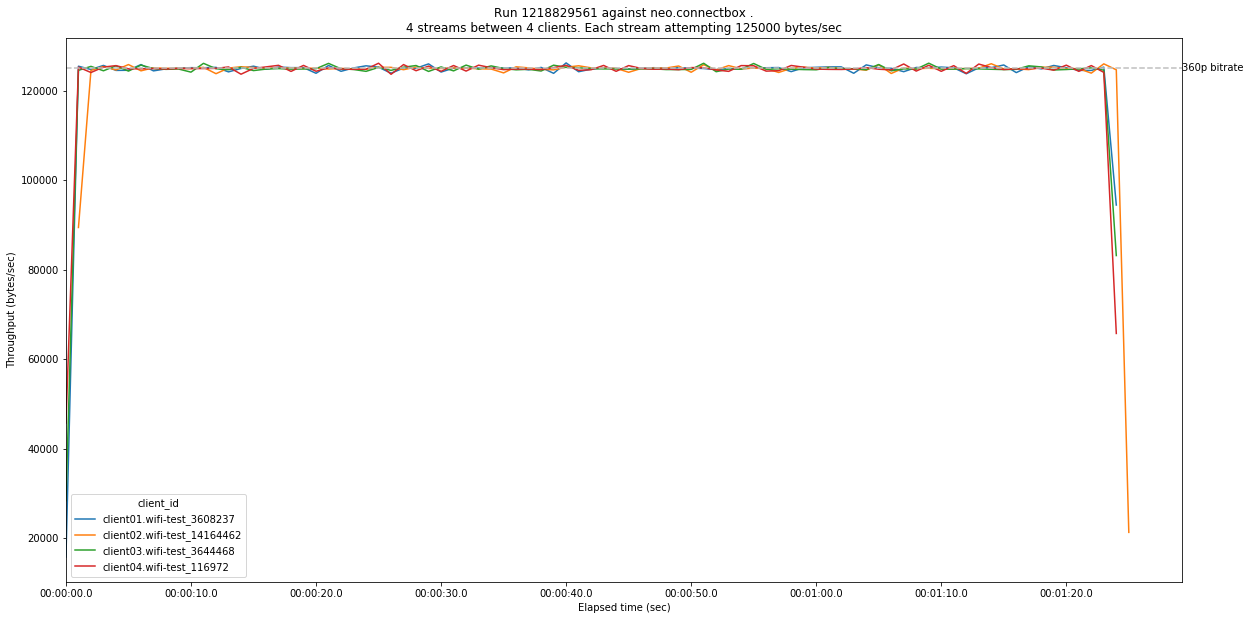

In [3]:
# Single runs
run_id = 2124364206 # pilot1 clients on 00
run_id = 1218829561 # pilot clients on AU
show_multiple_run_ids_as_line_graph([run_id])

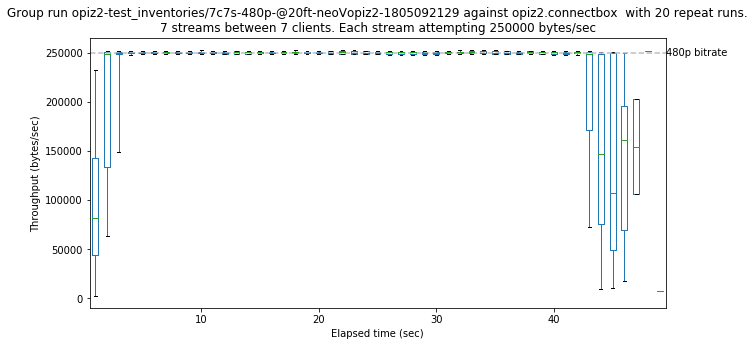

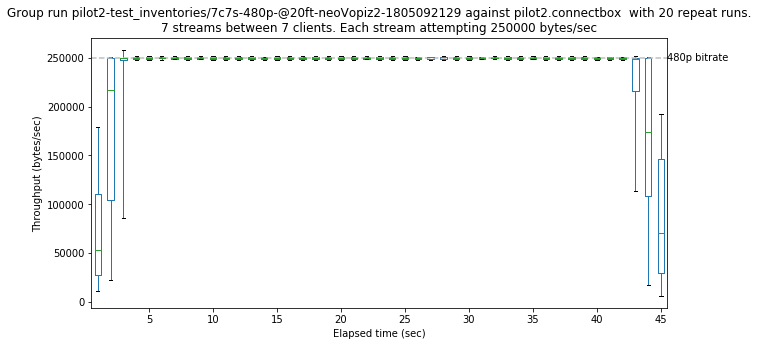

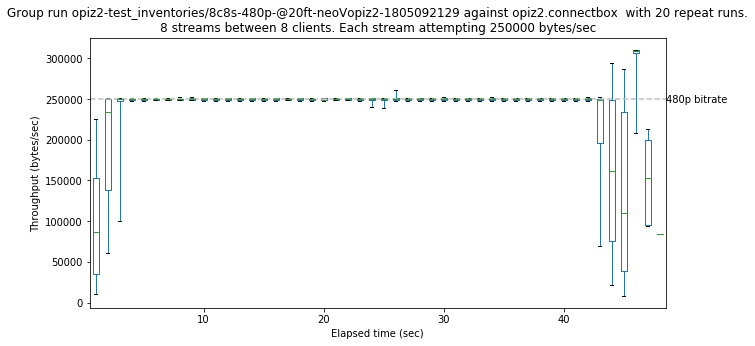

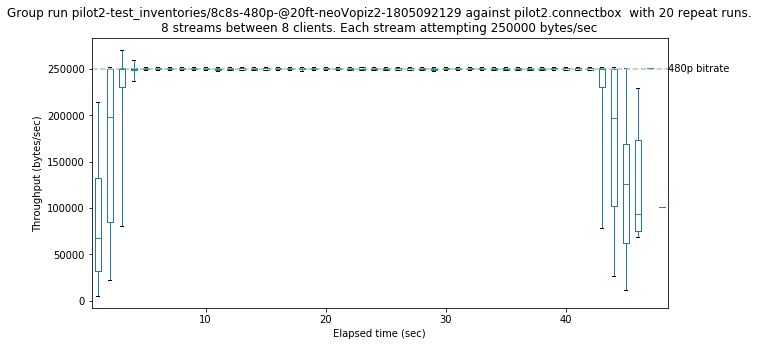

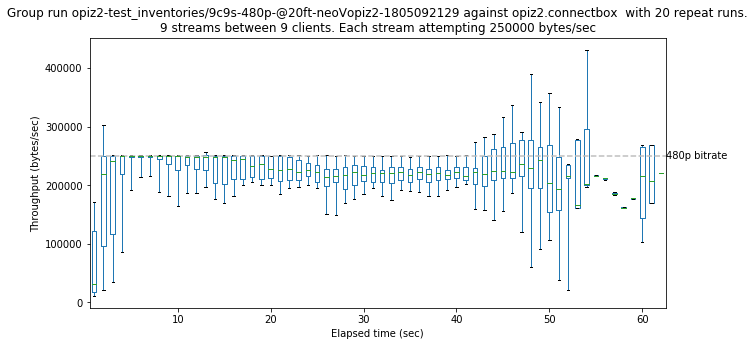

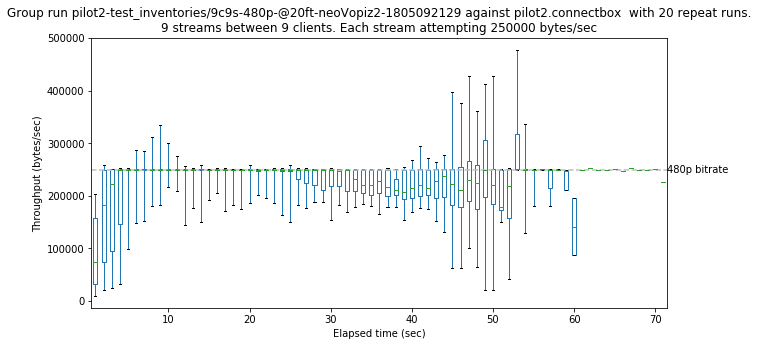

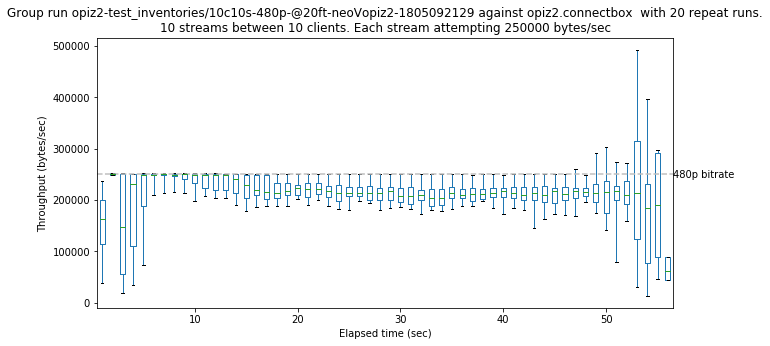

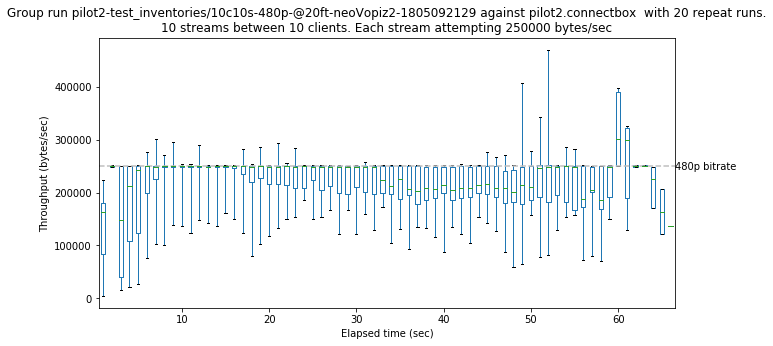

In [26]:
# Groups
"""
group_ids = [
    "opiz2-test_inventories/6c6s-480p-@20ft-neoVopiz2-1805082127",
    "pilot2-test_inventories/6c6s-480p-@20ft-neoVopiz2-1805082127",
    "opiz2-test_inventories/7c7s-480p-@20ft-neoVopiz2-1805082127",
    "pilot2-test_inventories/7c7s-480p-@20ft-neoVopiz2-1805082127",    
    "opiz2-test_inventories/9c9s-480p-@20ft-neoVopiz2-1805072151",
    "pilot2-test_inventories/9c9s-480p-@20ft-neoVopiz2-1805072151",
    "opiz2-test_inventories/10c10s-480p-@20ft-neoVopiz2-1805072151",
    "pilot2-test_inventories/10c10s-480p-@20ft-neoVopiz2-1805072151",
    "opiz2-test_inventories/11c11s-480p-@20ft-neoVopiz2-1805072151",
    "pilot2-test_inventories/11c11s-480p-@20ft-neoVopiz2-1805072151",
    "opiz2-test_inventories/8c8s-360p-@20ft-neoVopiz2-1805082127",
    "pilot2-test_inventories/8c8s-360p-@20ft-neoVopiz2-1805082127",
    "opiz2-test_inventories/10c10s-360p-@20ft-neoVopiz2-1805082127",
    "pilot2-test_inventories/10c10s-360p-@20ft-neoVopiz2-1805082127",
    "opiz2-test_inventories/12c12s-360p-@20ft-neoVopiz2-1805082127",
    "pilot2-test_inventories/12c12s-360p-@20ft-neoVopiz2-1805082127",
]
"""
group_ids = [
    "opiz2-test_inventories/7c7s-480p-@20ft-neoVopiz2-1805092129",
    "pilot2-test_inventories/7c7s-480p-@20ft-neoVopiz2-1805092129",
    "opiz2-test_inventories/8c8s-480p-@20ft-neoVopiz2-1805092129",
    "pilot2-test_inventories/8c8s-480p-@20ft-neoVopiz2-1805092129",
    "opiz2-test_inventories/9c9s-480p-@20ft-neoVopiz2-1805092129",
    "pilot2-test_inventories/9c9s-480p-@20ft-neoVopiz2-1805092129",
    "opiz2-test_inventories/10c10s-480p-@20ft-neoVopiz2-1805092129",
    "pilot2-test_inventories/10c10s-480p-@20ft-neoVopiz2-1805092129",
]

for group_id in group_ids:
    show_group_as_boxplot(group_id)
#show_multiple_run_ids_as_line_graph(get_test_run_ids_for_group_id(group_id))